# Car Price prediction
Предсказание стоимости автомобиля на разных типах данных с использованием различных моделей машинного обучения и нейросетей



## NLP
* Строим NLP модель для обработки тестовых описаний автомобиля.
* Данные NLP модели и NN модели объедяем в multiple inputs сеть.

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymystem3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Импортируем библиотеки

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# For NLP
import nltk
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.corpus import stopwords
#from pymystem3 import Mystem
from string import punctuation
import re

# For ML
# from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif


# Keras
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations


# Charts
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

# Функции

In [5]:
#метрика МАРЕ
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
!pip freeze > requirements.txt

# DATA

In [7]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
#загружаем уже предобработанный  датасет
data = pd.read_csv('../input/mydata/data.csv')

In [8]:
data.head(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,sample,price,mileage_prod_date,mileage_owns,owns_year
0,универсал 5 дв.,MERCEDES,чёрный,эксклюзивный проект 124 универсал 300te 24 spo...,3,220,бензин,350000,1984,W124,5,1991,1099427284,автоматическая,3,Оригинал,задний,0,0.0,175,116666,12
1,купе,BMW,белый,любимый тачил обвес тюнинг hamman ездить долж...,3,313,дизель,15000,2011,6ER,2,2013,1096405886,автоматическая,1,Оригинал,полный,0,0.0,7,15000,10


In [9]:
# Категориальные признаки
categorical_features = [
    'bodyType',
    'brand',
    'color',
    'fuelType',
    'model_info',
    'numberOfDoors',
    'vehicleTransmission',
    'Владельцы',
    'ПТС',
    'Привод'
]

# Числовые признаки
numerical_features = [
    'engineDisplacement',
    'mileage',
    'modelDate',
    'mileage_prod_date',
    'mileage_owns',
    'owns_year',
    'productionDate',
    'enginePower'
]

# PreProc Tabular Data

In [10]:
def preproc_data(df_input):

    df_output = df_input.copy()

    # убираем не нужные для модели признаки
    df_output.drop(['description', 'sell_id'], axis=1, inplace=True)

    # Логарифмирование
    for col in numerical_features:
        df_output[col] = np.log(df_output[col] + 1)
        #логарифмируем и таргет тоже
    # df_output['price'] = np.log(df_output['price'] + 1)

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:, 0]

    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes

    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(
        df_output, columns=categorical_features, dummy_na=False)

    return df_output

In [11]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,sample,price,mileage_prod_date,mileage_owns,owns_year,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,bodyType_13,bodyType_14,bodyType_15,bodyType_16,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,model_info_121,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7399,0.564575,0.528676,0.829686,0.896948,0.869500,1,1590000.0,0.641460,0.829686,0.428043,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
4273,0.564575,0.528676,0.763680,0.876307,0.895626,1,3100000.0,0.504212,0.763680,0.464411,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
3362,0.920782,0.919349,0.778972,0.876307,0.869500,1,3750000.0,0.535845,0.695253,0.125195,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1
2794,0.712414,0.528676,0.841535,0.834995,0.764868,1,1990000.0,0.666249,0.757815,0.214022,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

In [12]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 188 entries, engineDisplacement to Привод_2
dtypes: float64(9), int64(1), uint8(178)
memory usage: 2.1 MB


## Split data

In [13]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1) # на этой части будем тестировать

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 4: NLP + Multiple Inputs

In [15]:
data.description

0       эксклюзивный проект 124 универсал 300te 24 spo...
1        любимый тачил обвес тюнинг hamman ездить долж...
2        первый перебирать замена кольцо колпак ванос ...
3        отличный состояние весь родной краска красить...
4        немка бесключивый доступ камера задний вид пл...
                              ...                        
8348     любимый год эксплуатация вести просто великол...
8349     официальный дилер 2017 г третий владелец весь...
8350     торг место весь работать сборка немецкий рези...
8351     отличный состояние 3 семья обслуживание профи...
8352     удлиненный заводской pullman база w140 вообще...
Name: description, Length: 8353, dtype: object

In [16]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [17]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [18]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.22 s, sys: 2.98 ms, total: 1.22 s
Wall time: 1.22 s


In [19]:
tokenize.word_index

{'система': 1,
 'пробег': 2,
 'задний': 3,
 'сидение': 4,
 'весь': 5,
 'состояние': 6,
 'год': 7,
 'передний': 8,
 'диск': 9,
 '2': 10,
 'комплект': 11,
 'дилер': 12,
 'новый': 13,
 'официальный': 14,
 'ваш': 15,
 'кредит': 16,
 'фара': 17,
 'гарантия': 18,
 'пакет': 19,
 'руль': 20,
 'колесо': 21,
 'безопасность': 22,
 'комплектация': 23,
 'обмен': 24,
 'контроль': 25,
 'птс': 26,
 'зеркало': 27,
 'bmw': 28,
 '000': 29,
 'покупка': 30,
 'проверка': 31,
 'водитель': 32,
 'продажа': 33,
 'полный': 34,
 'шина': 35,
 'датчик': 36,
 'отличный': 37,
 'пассажир': 38,
 '1': 39,
 'резина': 40,
 'владелец': 41,
 'условие': 42,
 'подушка': 43,
 'ключ': 44,
 'подогрев': 45,
 'технический': 46,
 'обогрев': 47,
 'любой': 48,
 '6': 49,
 'хороший': 50,
 'обслуживание': 51,
 'проходить': 52,
 'км': 53,
 '3': 54,
 'юридический': 55,
 'оригинал': 56,
 'масло': 57,
 'стекло': 58,
 'торг': 59,
 'замена': 60,
 'дверь': 61,
 'черный': 62,
 'рулевой': 63,
 'электропривод': 64,
 'оригинальный': 65,
 'наш': 66

In [20]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.61 s, sys: 2.38 ms, total: 1.62 s
Wall time: 1.62 s


In [21]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

 проверять 110 пункт автокредит специальный ставка 13 7 ауди центр север официальный дилер audi входить группа компания рольф являться крупный дилер европа предлагать ряд услуга покупка продажа пробег протяжение многий год наш дилерский центр являться лидер продажа пробег среди весь дилер audi россия предоставлять клиент самый большой выбор пробег audi марка каждый проходить тщательный диагностика подготовка гарантировать находиться отличный состояние убеждаться правильный выбор возможность проходить тест драйв ознакомительный поездка интересовать смочь ознакомляться выходить дом наш менеджер проводить online презентация видеозвонок показывать выбирать также ауди центр север представлять уникальный предложение кредитование пробег индивидуальный условие специалист компания подбирать хороший условие кредитование 6 000 проверенный пробег гарантия 2 год ждать сайт rolf probeg мобильный приложение рольф
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  

### RNN NLP

In [35]:
K.clear_session()

model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [36]:
#Подбирая различные параметры активации и units, поняла, что лучше оставить активацию такую, какая она есть.
#Увеличение units улучшило результат
#Берем параметры из модели 3 - NN, они показали результат лучше, чем те, ктр в бэйзлайне
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
#активация sigmoid вместо relu ухудшила результат
#model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="sigmoid")) 
model.add(L.Dropout(0.5))
#model.add(L.BatchNormalization()) #добавила нормализацию - ухудшило результат
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))

### Multiple Inputs NN

In [37]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [38]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     5798912     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [39]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE', optimizer=optimizer, metrics=['MAPE'])

In [41]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [42]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,  # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

Epoch 1/500
12/12 [==============================] - 4s 320ms/step - loss: 97.9093 - MAPE: 97.9093 - val_loss: 90.3388 - val_MAPE: 90.3388
Epoch 2/500
12/12 [==============================] - 3s 254ms/step - loss: 69.8254 - MAPE: 69.8254 - val_loss: 32.4698 - val_MAPE: 32.4698
Epoch 3/500
12/12 [==============================] - 3s 245ms/step - loss: 38.1691 - MAPE: 38.1691 - val_loss: 30.2494 - val_MAPE: 30.2494
Epoch 4/500
12/12 [==============================] - 3s 248ms/step - loss: 32.2781 - MAPE: 32.2781 - val_loss: 26.9560 - val_MAPE: 26.9560
Epoch 5/500
12/12 [==============================] - 3s 248ms/step - loss: 28.2328 - MAPE: 28.2328 - val_loss: 24.9239 - val_MAPE: 24.9239
Epoch 6/500
12/12 [==============================] - 3s 247ms/step - loss: 25.3620 - MAPE: 25.3620 - val_loss: 21.6092 - val_MAPE: 21.6092
Epoch 7/500
12/12 [==============================] - 3s 253ms/step - loss: 22.9950 - MAPE: 22.9950 - val_loss: 19.9962 - val_MAPE: 19.9962
Epoch 8/500
12/12 [========

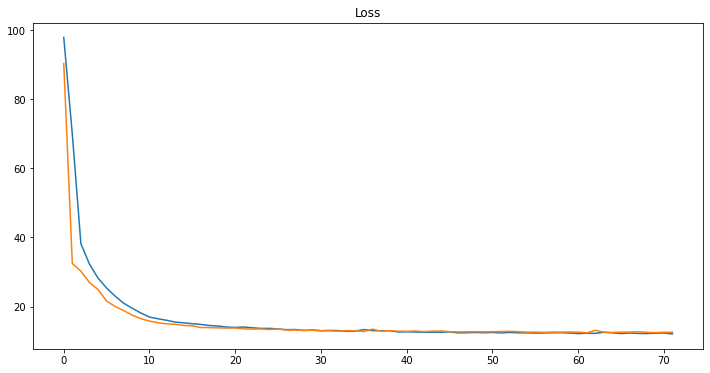

In [43]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [44]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [45]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.57%


In [47]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])

sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission.to_csv('without_round_nn2.csv', index=False)

# округлим
sample_submission['price'] = (sample_submission['price'] // 1000) * 1000

sample_submission.to_csv('nn2_submission.csv', index=False)

## Вывод по  части 3:¶
* Построена NLP модель для обработки тестовых описаний автомобиля.
* Данные NLP модели и NN модели объеденены в multiple inputs сеть.
* С помощью обработки текстов описаний удалось улучшить метрику по сравнению с бэйзлайном
* Достигнут показатель МАРЕ: 12.88%.